# Advanced hashtag analysis: Twitter data

In [120]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

In [126]:
src = '/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Updates'

df = pd.read_csv(join(src, 'IchBinHanna_23_06.csv'), encoding='utf-8', dtype='unicode', 
                   parse_dates=['created_at']).apply(lambda x: x.astype(str).str.lower())
# df = df.astype(str)

In [140]:
# Run this to check how the text looks like
df['text']

0        #ichbinhanna, 31, und studiere im 26. semester...
1        rt @schorn_stephan: #ichbinhanna, 31, und stud...
2        die antwort des bmbf auf die flut von #ichbinh...
3        rt @schuh_melissa: die antwort des bmbf auf di...
4        hanna hält durch unbezahlte mehrarbeit forschu...
                               ...                        
43510    outpouring of online fury under #ichbinhanna i...
43511    rt @timeshighered: outpouring of online fury u...
43512    rt @steffen_siegel: modelle einer universitäts...
43513    rt @sozmethode: 4. dann wird darauf eingegange...
43514    rt @drkeichhorn: wieder ein artikel ohne echte...
Name: text, Length: 43515, dtype: object

# Hashtag analysis

## Create multiple new entities and assemble hashtags

This code creates new fields with multiple hashtags for each tweet and one field with popular hashtags.
Credits go to [Out Coding Club and James](https://ourcodingclub.github.io/tutorials/topic-modelling-python/).

Some preprocessing in the form of new modules:

In [121]:
# df['text'] = df['text'].apply(lambda col: col.str.lower())
# df

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn

# package to clean text
import re

And let's define the main variables

In [168]:
def find_hashtags(text):
    '''This function will extract hashtags'''
    return re.findall('\B#\w*[a-zA-Z]+\w*', text, re.UNICODE) # Options: ""(?:^|\s)[＃#]{1}(\w+)" "\B#\w*[a-zA-Z]+\w*" And: The original code uses another section to find hashtags, which does not work for German: (#[A-Za-z]+[A-Za-z0-9-_]+)

df['hashtags'] = df.text.apply(find_hashtags, lambda col: col.str.lower())

# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

The next cell is for some initial execution. We will get the same results here as with the alternative code above

In [169]:
# number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

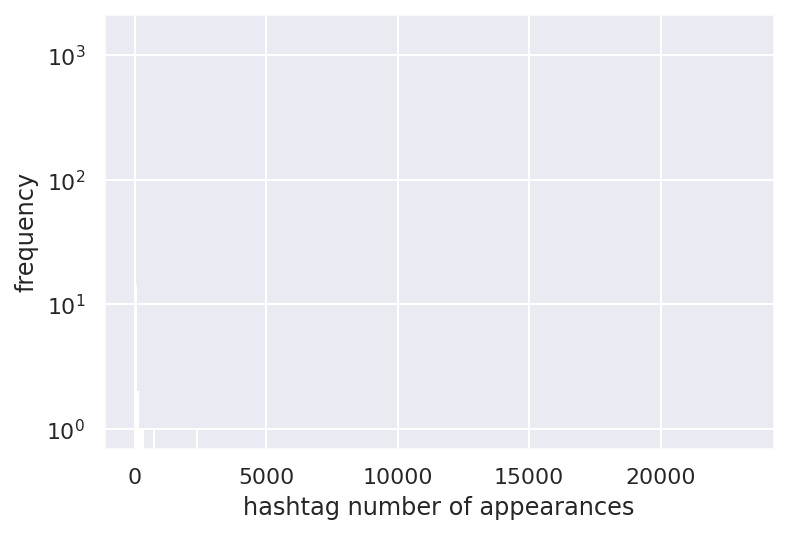

hashtag
#ichbinhanna                    23151
#wisszeitvg                      2352
#ichbinhannah                     744
#95vswisszeitvg                   322
#acertaindegreeofflexibility      230
#bmbf                             224
#wissenschaft                     211
#openaccess                       142
#dauerstellen                     134
#digitalhumanities                134
#frististfrust                    129
#woisthanna                       125
#wisskomm                         119
#metoo                            113
#bundestag                        108
#hannaimbundestag                  79
#f                                 75
#wi                                64
#wissz                             61
#bipocs                            60
#wissenschaftler                   59
#facebook_marketing                54
#ads_campaign                      54
#facebook_ads                      54
#digital_marketing                 54
#social_media_marketing            54
#ich

In [190]:
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonpositive='clip')
plt.show()
flattened_hashtags_df.value_counts('hashtag')[0:50]

## Vectorization: See how hashtags are related to each other
Let's prepare data first, building on the slower approach above

In [187]:
# take hashtags which appear at least this amount of times. Increase min_appearance if graph below is too large
min_appearance = 80
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]


for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

# hashtag_vector_df.head # Uncommen this to see how the vector is coded

In [188]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

# calculate the correlation matrix
correlations = hashtag_matrix.corr()

### Correlation matrix: seaborn

Now this is what we're doing below:
We want to find the correlation between each column of the dataframe and thus the correlation between the different hashtags appearing in the same tweets.
As defined above, e can’t correlate hashtags which only appear once, and we don’t want hashtags that appear a low number of times since this could lead to spurious correlations.

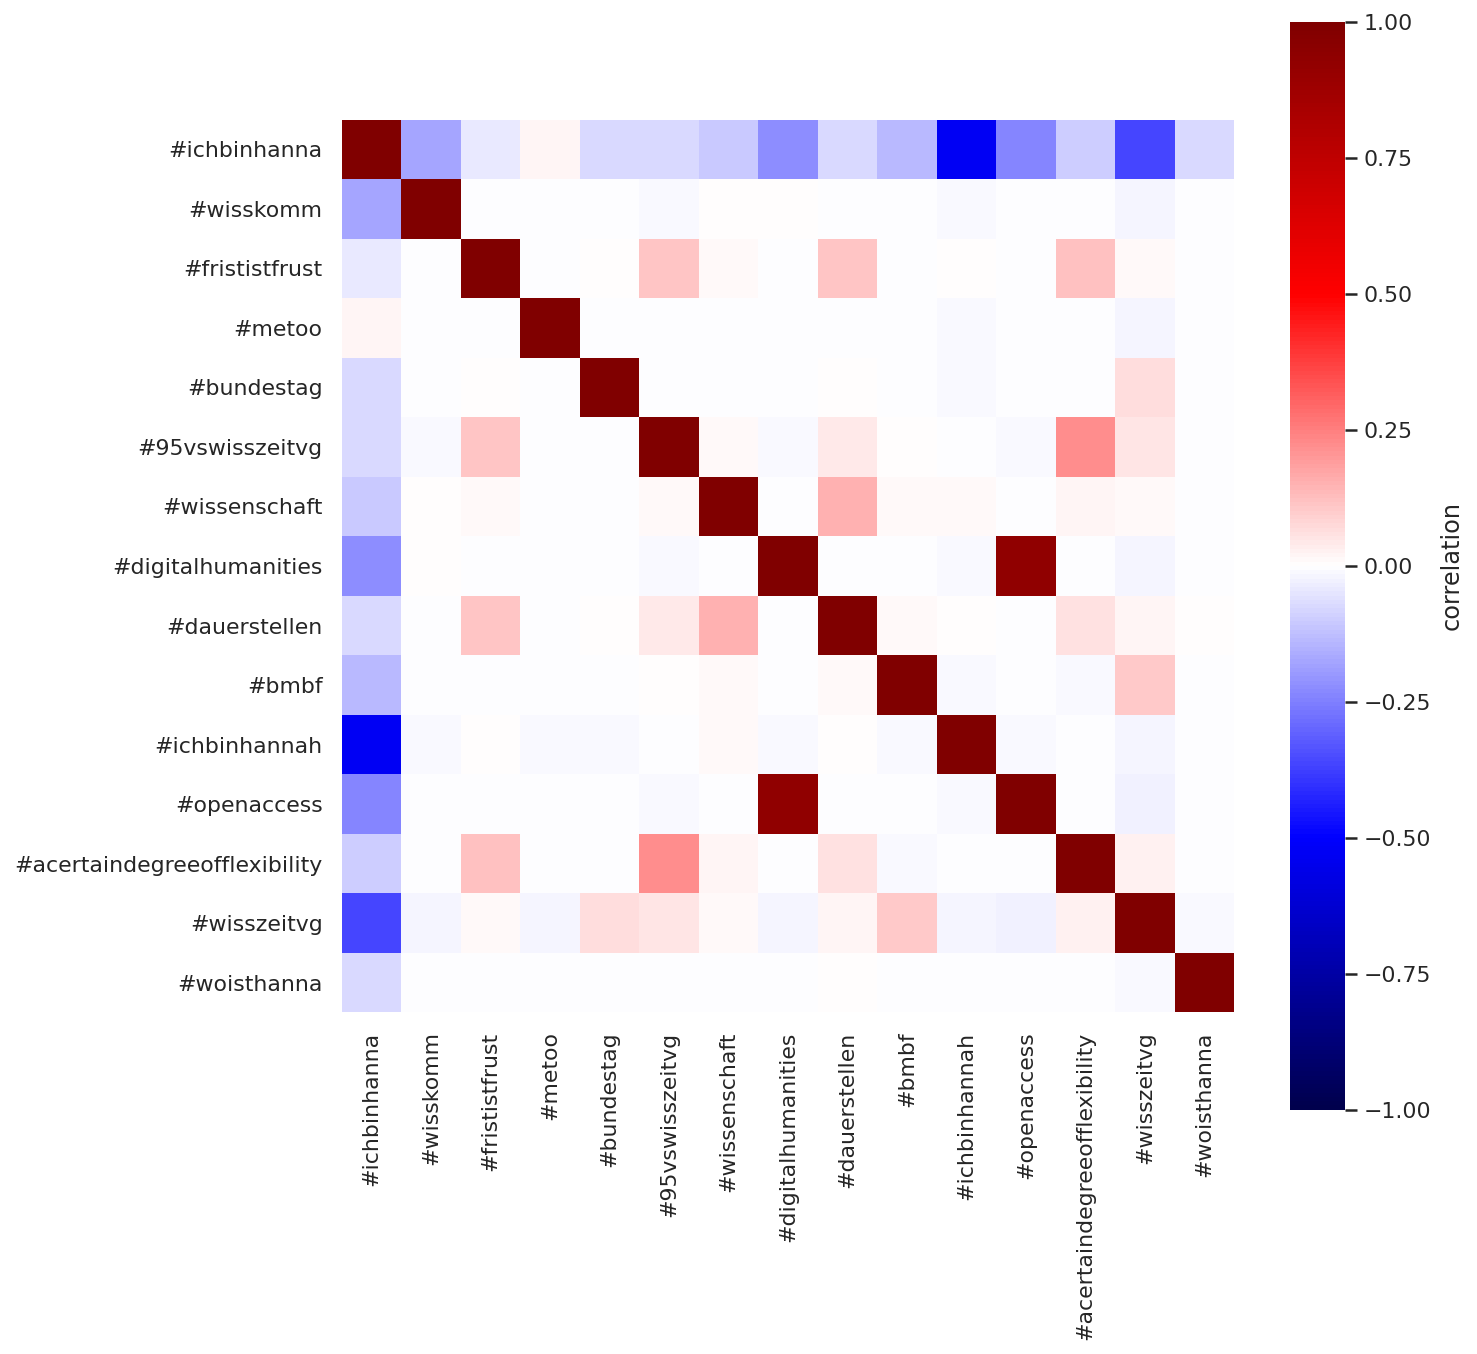

In [189]:
import seaborn as sns

# model building package
import sklearn

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='seismic', # RdBu, GnBu, seismic, bwr, magma More https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
    vmin=-1,
    vmax=1,
    square = True,
    # annot = True, fmt='.1', # To get numbers
    cbar_kws={'label':'correlation'}) # perhaps include , 'orientation': 'horizontal'


plt.savefig("/media/s/Linux_storage/GitHub/-IchbinHanna/plots/hashtag_correlation_IchBinHanna.png", dpi=400)
plt.show()

### Correlation matrix: heatmapz
The difference below is that we get the size of correlation, which is directly related to the colour. Readability is thus improved. More [info on the module's website](https://pypi.org/project/heatmapz/)

In [191]:
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
# !pip install heatmapz

In [193]:
# Import the two methods from heatmap library
from heatmap import heatmap, corrplot

Create correlation matrix with size

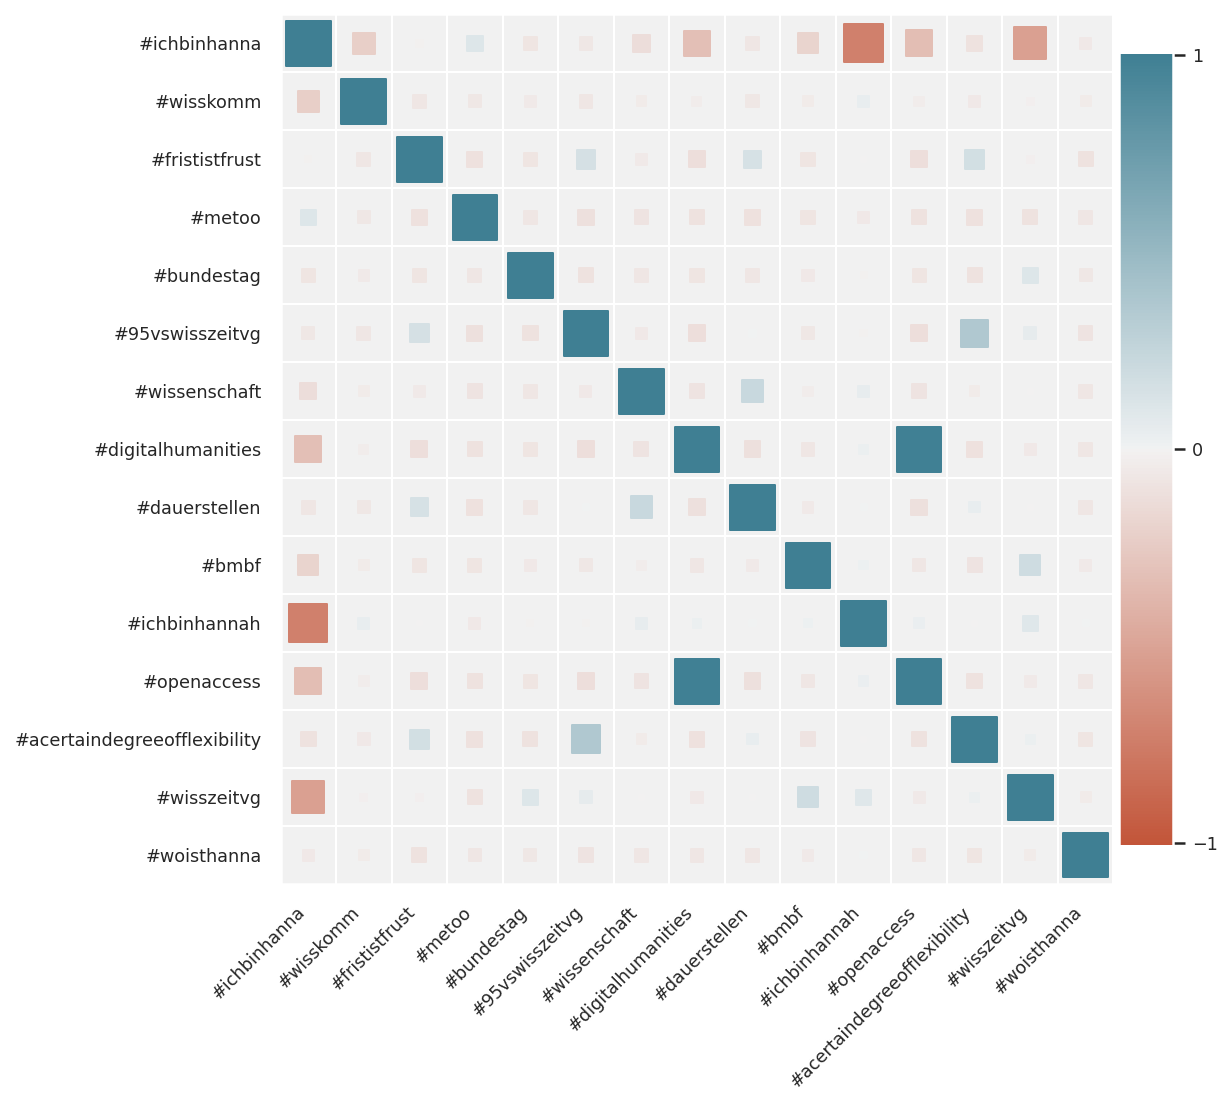

In [206]:
rcParams['figure.figsize'] = 7,7 
sns.set(color_codes=True, font_scale=0.8)
plt.figure(figsize=(8, 8))
corrplot(correlations.corr(), size_scale=500) 
# Adjust size-scale according to figure size. 
# Increasing the scale improves readability but also distorts
# Use marker='' for different shapes. 
# See also https://matplotlib.org/stable/api/markers_api.html
# For colours see https://seaborn.pydata.org/tutorial/color_palettes.html
plt.savefig("/media/s/Linux_storage/GitHub/-IchbinHanna/plots/hashtag_correlation_IchBinHanna_heatmapz.png", dpi=400)

## Alternative: This is yet another working option for quickly assessing hashtag frequenc

In [22]:
text = "#promovolt #1st # promovolt #123 #Bundesmobilitätsgesetz"

In [53]:
hashtag_re = re.compile("(?:^|\s)[＃#]{1}(\w+)", re.UNICODE)
# hashtag_re.findall(text) # print example

['promovolt', '1st', '123', 'Bundesmobilitätsgesetz']

In [ ]:
# Adjust path accordingly, for Windows use r"...", for Linux don't use r...
tweets = pd.read_csv(".../Bundesmobilitaetsgesetz.csv", 
                     encoding="utf-8", dtype="unicode") # read

tweets[['text']].fillna(0) # In case of an error

tweets = ' '.join(list(tweets['text'].astype(str).str.lower())) # Tweet preprocessing: lower case.  Remove `.str.lower()` to get more than lower case
# Ist weiteres preprocessing notwendig? Eher nicht, da Hashtags in ihren genauen Formulierungen relevant sind. Ansonsten mehr: https://textmining.wp.hs-hannover.de/Preprocessing.html
hashtag_re = re.compile(r'\B#\w*[a-zA-Z]+\w*', re.UNICODE) # Alternative expression, also without #: "(?:^|\s)[＃#]{1}(\w+)"
# hashtag_re.findall(tweets) print example

In [5]:
freq_tweets = pd.Series(hashtag_re.findall(tweets)).value_counts().sort_values(ascending=False)